In [5]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import time
from IPython import display

from pymavlink import mavutil, mavparm
try:
    import daqflex
    import daqutil
except ImportError as e:
    print(e)
    pass

import px4_logutil

import pyttsx
text2speech = pyttsx.init()
voices = text2speech.getProperty('voices')
voice = voices[16]
text2speech.setProperty('voice', voice.id)
text2speech.setProperty('rate', 200)
text2speech.setProperty('voice', 16)
text2speech.say('Text to speed initialized.')
text2speech.runAndWait()

rcParams['figure.figsize'] = (15,5)

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
No module named 'daqflex'


SyntaxError: invalid syntax (px4_logutil.py, line 71)

# Measured Data

In [170]:
m = 0.012 # mass of vehicle (12 grams)

# Calibration

Find offsets by finding data with no load applied, note should flip on z-axis and average to account for gravity effect.

In [216]:
try:
    if 'daq' not in locals().keys() or daq is None:
        daq = daqflex.USB_1608G()
    cal_matrix, max_mat = daqutil.load_calibration(
        os.path.join('calibration','FT15818.cal'))
    calib_data = daqutil.aiscan(daq, fs=20000, tf=5)
    offsets = calib_data['ai'].mean(axis=0)
    print offsets
    daq_connected = True
except ValueError as e:
    print e
    daq = None
    offsets = None
    cal_matrix = None

[ 20573.8821   33724.80684  33484.62643  40165.98265  40109.75351
  38088.56311  22839.04779  22860.02693]


# Data Acquisition No Wind/ Flap

loading
F: [  5.44879719e-06  -3.44817881e-04  -2.81035901e-04] N
M: [-0.00769138 -0.00937952  0.00086127] N-m


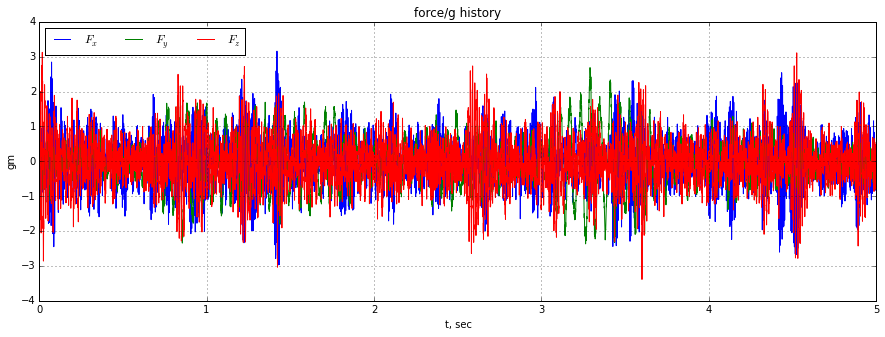

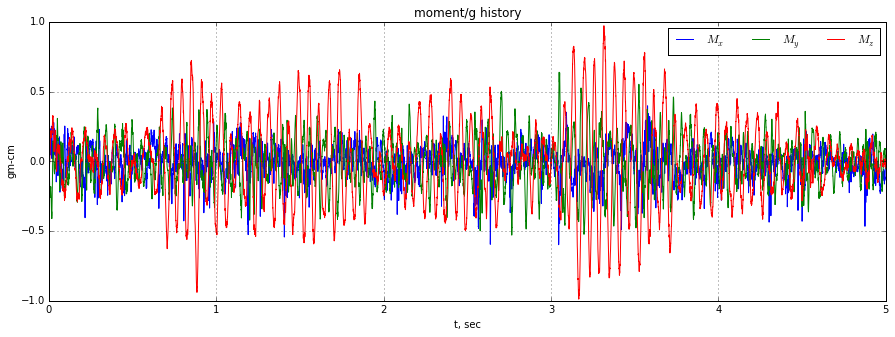

In [217]:
data_no_flap = daqutil.aiscan_or_load_data(
    filename=os.path.join('data', 'fwav', 'no_flap.pkl'),
    daq=daq,
    fs=20000, tf=5,
    offsets=offsets,
    cal_matrix=cal_matrix,
    force_run=False)
data_no_flap_lp = daqutil.low_pass_data(data_no_flap, 1000)
daqutil.plot_forces(data_no_flap_lp)
figure()
daqutil.plot_moments(data_no_flap_lp)
daqutil.print_mean_force_moment(data_no_flap)

#Before Learning, Tunnel Velocity Running

F: [ 0.03739152 -0.08378063  1.05672913] N
M: [-32.87323973 -12.81044301   1.99076119] N-m


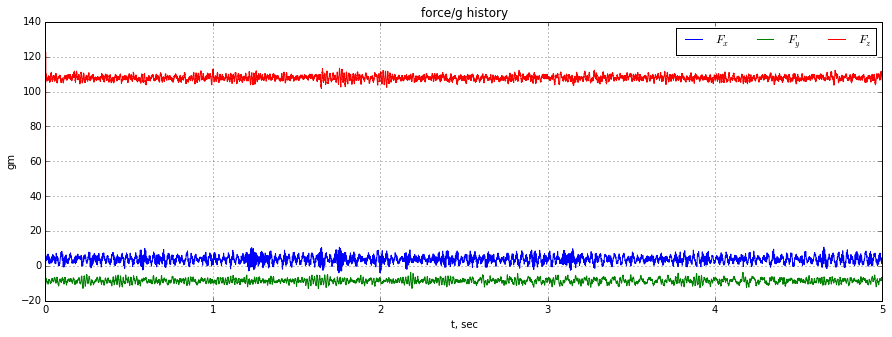

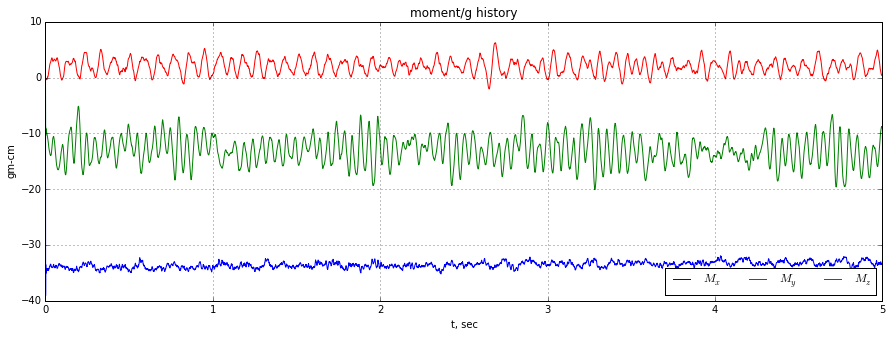

In [59]:
data_no_learn = daqutil.aiscan_or_load_data(
    filename=os.path.join('data', 'fwav', 'no_learn.pkl'),
    daq=daq,
    fs=20000, tf=5,
    offsets=offsets,
    cal_matrix=cal_matrix,
    force_run=True)
data_no_learn_lp = daqutil.low_pass_data(data_no_learn, 1000)
daqutil.plot_forces(data_no_learn_lp)
figure()
daqutil.plot_moments(data_no_learn_lp)
daqutil.print_mean_force_moment(data_no_learn)

In [60]:
inh202mps = 63.8

In [61]:
1.5/inh202mps

0.023510971786833857

In [62]:
inh20 = 0.024 # tunnel at 6 Hz

In [63]:
v = inh20*inh202mps
v

1.5312

# Check Max Torque/ Force

In [64]:
nm2gcm = 10197.16
overloadT = 1.6*nm2gcm
overloadT

16315.456

In [65]:
n2gm = 101.971621298
overloadF = 250*n2gm
overloadF

25492.9053245

In [66]:
data_no_flap['t']

array([  0.00000000e+00,   5.00005000e-05,   1.00001000e-04, ...,
         4.99990000e+00,   4.99995000e+00,   5.00000000e+00])

In [67]:
def check_max_force_torque():
    nm2gcm = 10197.16
    overloadT = 1.6*nm2gcm
    n2gm = 101.971621298
    overloadF = 250*n2gm
    dt = 1.5
    for i in range(1000):
        data_no_flap = daqutil.aiscan_or_load_data(
            filename=os.path.join('data', 'fwav', 'no_static.pkl'),
            daq=daq,
            fs=20000, tf=dt,
            offsets=offsets,
            cal_matrix=cal_matrix,
            force_run=True)
        data_no_flap_lp = daqutil.low_pass_data(data_no_flap, 1000)
        subplot(211)
        #cla()
        t = data_no_flap['t']
        #hlines(-overloadF, 0, dt)
        #hlines(overloadF, 0, dt)
        daqutil.plot_forces(data_no_flap_lp)
        subplot(212)
        #cla()
        #hlines(-overloadT, 0, dt)
        #hlines(overloadT, 0, dt)
        daqutil.plot_moments(data_no_flap_lp)
        display.clear_output(wait=True)
        display.display(gcf())

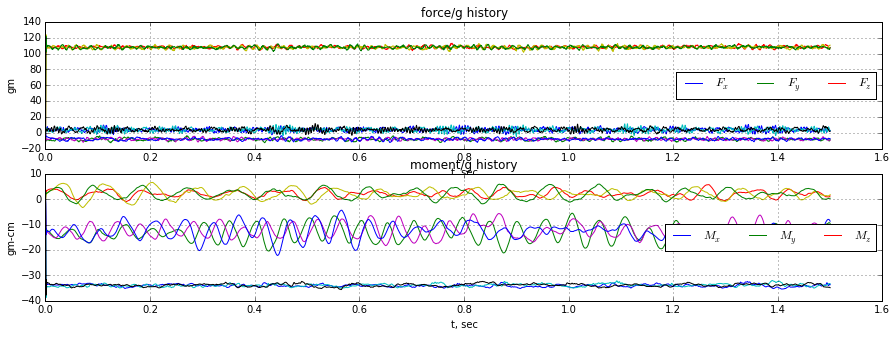

In [68]:
try:
    check_max_force_torque()
except KeyboardInterrupt:
    pass
close()

In [276]:
def do_learning_experiment(dev="/dev/ttyUSB0", baud=57600):
    mavutil.set_dialect("pixhawk")
    mav1 = mavutil.mavserial(dev, baud)

    dt = 7.5;
    tf = 10000;

    for t in arange(0, tf, dt):
        data = daqutil.aiscan_or_load_data(
            filename=os.path.join('data', 'fwav', 'data_test.pkl'),
            daq=daq,
            fs=20000, tf=dt,
            offsets=offsets,
            cal_matrix=cal_matrix,
            force_run=True)
        data_lp = daqutil.low_pass_data(data, 10)
        F = data['F'].mean(0)
        M = data['M'].mean(0)
        mav1.mav.vicon_position_estimate_send(t*1e6, F[0], F[1], F[2], M[0], M[1], M[2]);
        #daqutil.print_mean_force_moment(data)
        f = -F[2]/F[0]-abs(F[1])-1.0*(0.01*abs(M[0])+2*abs(M[1]-12)+2*abs(M[2]))
        text2speech.say('{:4.3f}'.format(f))
        print "L:\t{:6.4f}, D:\t{:6.4f}, S:\t{:6.4f}\nroll:\t{:6.4f}, pitch:\t{:6.4f}, yaw:\t{:6.4f}".format(
            F[2], F[0], -abs(F[1]), -0.01*abs(M[0]), -2*abs(M[1]-12), -2*abs(M[2]))
        print 'fitness: {:4.3f}'.format(f)
        print 'L/D: {:4.3f}'.format(-F[2]/F[0])

        subplot(211)
        cla()
        daqutil.plot_forces(data_lp)
        subplot(212)
        cla()
        daqutil.plot_moments(data_lp)
        display.clear_output(wait=True)
        display.display(gcf())
        
    close()

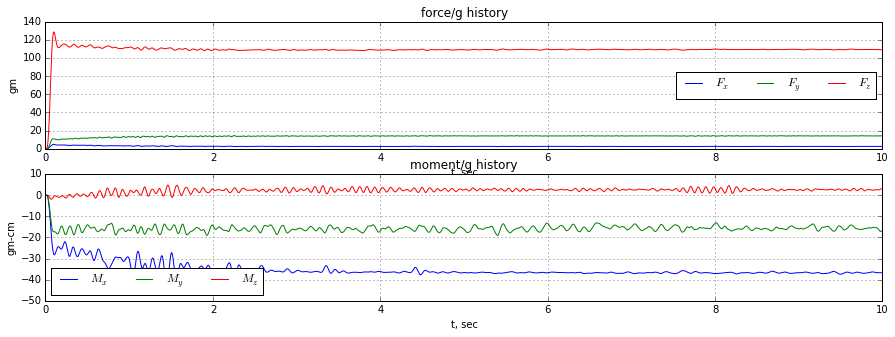

  50


In [78]:
try:
    do_learning_experiment("/dev/ttyUSB1", 57600)
except KeyboardInterrupt:
    pass
close()

# Test 1

In [15]:
with open('data/fwav/log_test1/sess006/log001.csv') as f:
    log = px4_logutil.px4_log_to_namedtuple(f)

In [16]:
def get_data_from_log(log, i_start, i_end):
    smooth_window = 13
    smooth_order = 1
    t = (log.TIME.StartTime[i_start:i_end] - log.TIME.StartTime[i_start])/1e6
    dt = px4_logutil.savitzky_golay(t, smooth_window, smooth_order, 1)
    airspeed = log.AIRS.TrueSpeed[i_start:i_end];
    # check right/left correct
    leftWing = (log.OUT0.Out0[i_start:i_end] + log.OUT0.Out1[i_start:i_end])/2
    rightWing = (log.OUT0.Out1[i_start:i_end] + log.OUT0.Out1[i_start:i_end])/2
    throttle = (log.OUT0.Out1[i_start:i_end] + log.OUT0.Out1[i_start:i_end])/2
    V_batt = log.BATT.VFilt[i_start:i_end]
    fx = log.VICN.X[i_start:i_end]
    fy = log.VICN.Y[i_start:i_end]
    fz = log.VICN.Z[i_start:i_end]
    mx = log.VICN.Roll[i_start:i_end]
    my = log.VICN.Pitch[i_start:i_end]
    mz = log.VICN.Yaw[i_start:i_end]
    fit = -10*fz  - mx**2 - my**2
    C_batt = log.BATT.C[i_start:i_end]
    return px4_logutil.dict_to_namedtuple('data', locals())

In [17]:
data = get_data_from_log(log, 1, -1)

## This is problematic, we weren't getting airspeed.

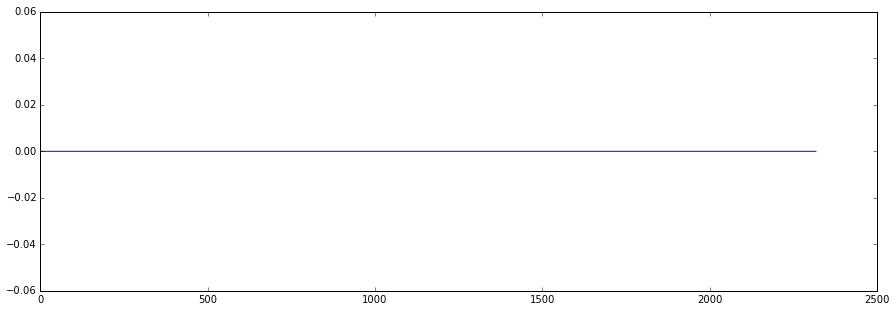

In [18]:
plot(data.t, data.airspeed)

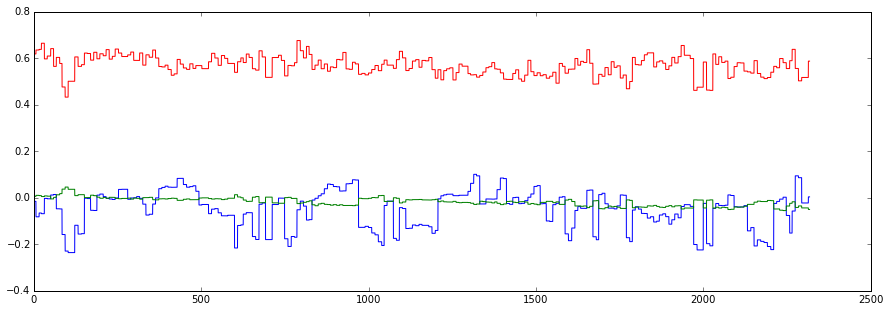

In [19]:
plot(data.t, data.fx)
plot(data.t, data.fy)
plot(data.t, data.fz)

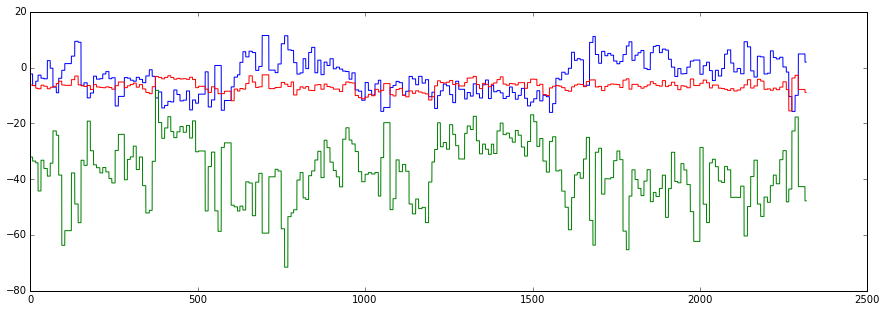

In [20]:
plot(data.t, data.mx)
plot(data.t, data.my)
plot(data.t, data.mz)

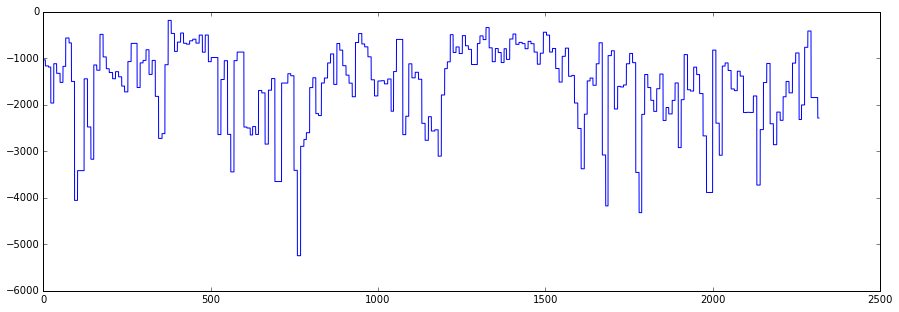

In [21]:
plt.plot(data.t, -10*data.fx - data.mx*data.mx - data.my*data.my)

## Observations/ Ideas
Testing idea, set flapping freq to make F_z equal weight, (averaged over a long time), then optimize battery current with flapping parameters.

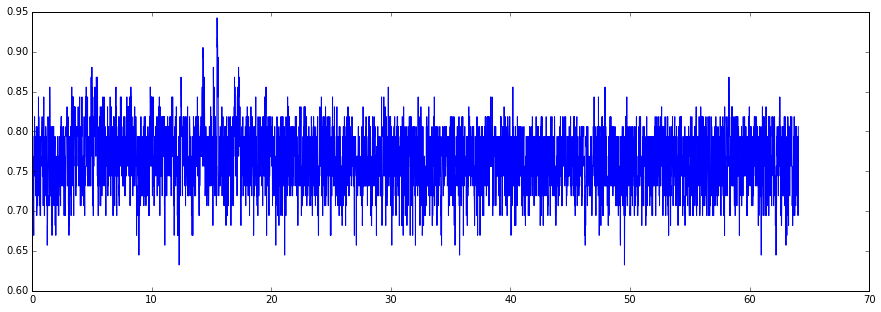

In [22]:
plt.plot(data.t[0:5000], data.C_batt[0:5000])

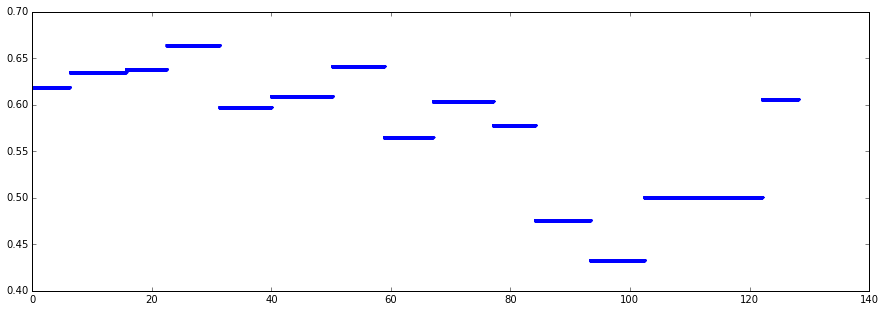

In [28]:
plot(data.t[0:10000], data.fz[0:10000], '.')

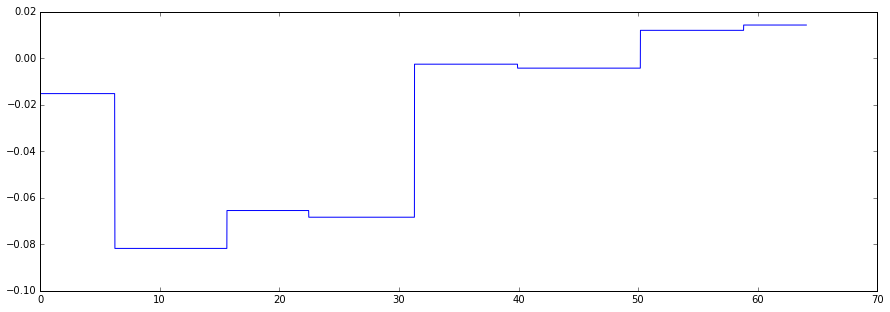

In [24]:
plt.plot(data.t[0:5000], data.fx[0:5000])

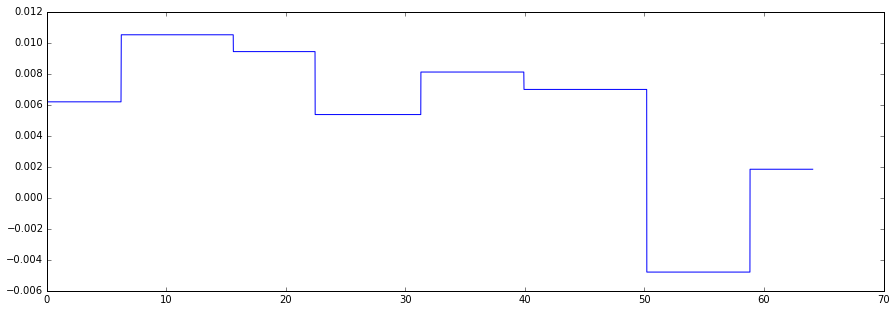

In [25]:
plt.plot(data.t[0:5000], data.fy[0:5000])

In [12]:
import pyttsx
engine = pyttsx.init()
voices = engine.getProperty('voices')
voice = voices[16]
engine.setProperty('voice', voice.id)
engine.setProperty('rate', 300)
engine.setProperty('voice', 16)

for i in range(2):
    engine.say('Z -1002.34'.format(i))

# Test2 (High Mutation)

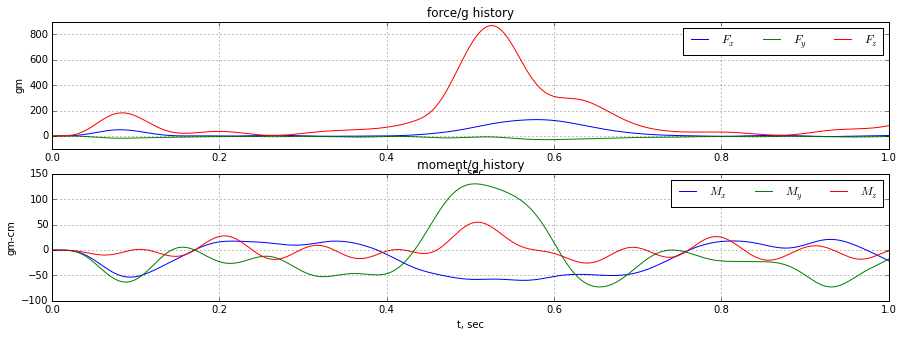

  27


In [90]:
try:
    do_learning_experiment("/dev/ttyUSB0", 57600)
except KeyboardInterrupt:
    pass
close()

F: [ 0.36004872 -0.11718723  2.24532863] N
M: [-20.70318168   3.75254384   2.07865532] N-m


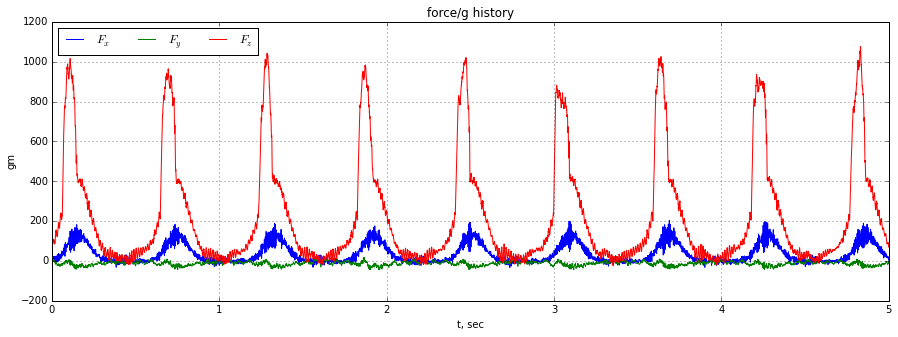

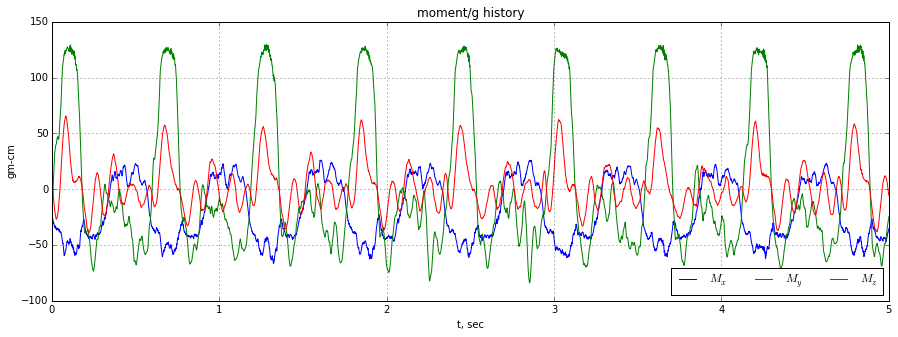

In [89]:
data_no_learn = daqutil.aiscan_or_load_data(
    filename=os.path.join('data', 'fwav', 'no_learn2.pkl'),
    daq=daq,
    fs=20000, tf=5,
    offsets=offsets,
    cal_matrix=cal_matrix,
    force_run=True)
data_no_learn_lp = daqutil.low_pass_data(data_no_learn, 1000)
daqutil.plot_forces(data_no_learn_lp)
figure()
daqutil.plot_moments(data_no_learn_lp)
daqutil.print_mean_force_moment(data_no_learn)

In [ ]:
try:
    do_learning_experiment("/dev/ttyUSB1", 57600)
except KeyboardInterrupt:
    pass
close()

F: [-0.0184561   0.06723763  1.4278218 ] N
M: [-25.10280755   4.62787384  -4.80512961] N-m


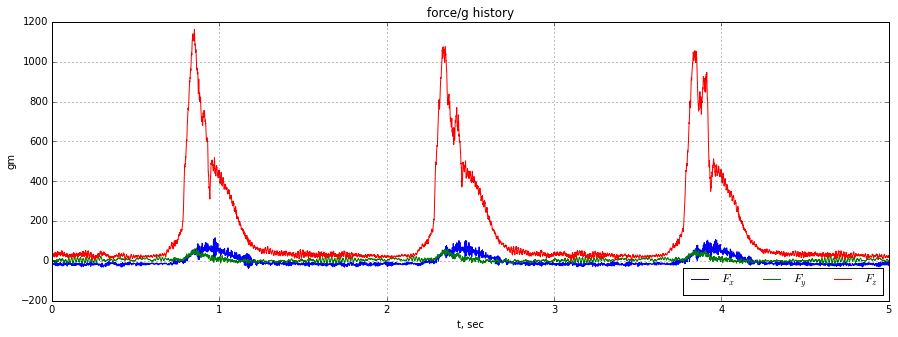

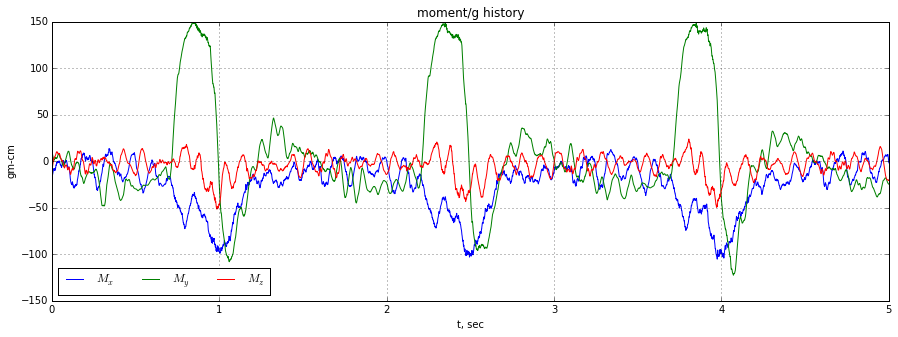

In [268]:
data_no_learn3 = daqutil.aiscan_or_load_data(
    filename=os.path.join('data', 'fwav', 'no_learn3.pkl'),
    daq=daq,
    fs=20000, tf=5,
    offsets=offsets,
    cal_matrix=cal_matrix,
    force_run=True)
data_no_learn3_lp = daqutil.low_pass_data(data_no_learn3, 1000)
daqutil.plot_forces(data_no_learn3_lp)
figure()
daqutil.plot_moments(data_no_learn3_lp)
daqutil.print_mean_force_moment(data_no_learn3)